In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from joblib import dump, load

from nltk.tokenize import RegexpTokenizer
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb

from util import *
%matplotlib inline


In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

train['train_test'] = 'train'
test['train_test'] = 'test'

data = pd.concat([train, test])

/home/aims/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [3]:
data['sentiment'] = data['description'].apply(lambda x : sentiment_analyzer_scores(x,'compound'))

In [4]:
data.sentiment.describe()

count    258210.000000
mean          2.568456
std           0.585724
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           3.000000
Name: sentiment, dtype: float64

In [5]:
data.shape

(258210, 17)

In [6]:
test.shape

(83210, 16)

In [7]:
data.head(2)

,country,description,designation,id,index,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,train_test,variety,winery,sentiment
0,Portugal,This is a fine rich balanced wine. It has ripe...,Vila Santa Reserva,32027,NaN,88.870874,20.0,Alentejano,NaN,NaN,NaN,NaN,NaN,train,PORTUGUESE RED,J. Portugal Ramos,3
1,France,"A solid, chunky wine, with a structure that is...",NaN,71079,NaN,88.041695,28.0,Bordeaux,Lalande de Pomerol,NaN,NaN,NaN,NaN,train,BORDEAUX-STYLE RED BLEND,Château Tour Grand Colombier,3


In [8]:
data['variety'].mode()

0    PINOT NOIR
dtype: object

In [9]:
data.variety.fillna(value='PINOT NOIR', inplace=True)

In [10]:
data.province.fillna(value='California', inplace=True)

In [11]:
data = data[pd.notnull(data['variety'])]
data = data[pd.notnull(data['province'])]

In [12]:
data.taster_name.fillna(value='Roger Voss', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258210 entries, 0 to 83209
Data columns (total 17 columns):
country                  258146 non-null object
description              258210 non-null object
designation              181120 non-null object
id                       258210 non-null int64
index                    83210 non-null float64
points                   258210 non-null float64
price                    175000 non-null float64
province                 258210 non-null object
region_1                 215793 non-null object
region_2                 110996 non-null object
taster_name              258210 non-null object
taster_twitter_handle    91559 non-null object
title                    120975 non-null object
train_test               258210 non-null object
variety                  258210 non-null object
winery                   258210 non-null object
sentiment                258210 non-null int64
dtypes: float64(3), int64(2), object(12)
memory usage: 35.5+ MB


In [13]:
data.title.fillna(value='Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258210 entries, 0 to 83209
Data columns (total 17 columns):
country                  258146 non-null object
description              258210 non-null object
designation              181120 non-null object
id                       258210 non-null int64
index                    83210 non-null float64
points                   258210 non-null float64
price                    175000 non-null float64
province                 258210 non-null object
region_1                 215793 non-null object
region_2                 110996 non-null object
taster_name              258210 non-null object
taster_twitter_handle    91559 non-null object
title                    258210 non-null object
train_test               258210 non-null object
variety                  258210 non-null object
winery                   258210 non-null object
sentiment                258210 non-null int64
dtypes: float64(3), int64(2), object(12)
memory usage: 35.5+ MB


In [14]:
data['province'] = pd.Categorical(data['province'])
proDummies = pd.get_dummies(data['province'], prefix = 'prov')

data['country'] = pd.Categorical(data['country'])
countDummies = pd.get_dummies(data['country'], prefix = 'country')

data['variety'] = pd.Categorical(data['variety'])
varDummies = pd.get_dummies(data['variety'], prefix = 'variety')

data['taster_name'] = pd.Categorical(data['taster_name'])
tastDummies = pd.get_dummies(data['taster_name'], prefix = 'taster')

data['sentiment'] = pd.Categorical(data['sentiment'])
sentiDummies = pd.get_dummies(data['sentiment'], prefix = 'sentiment')

#data['title'] = pd.Categorical(data['title'])
#titleDummies = pd.get_dummies(data['title'], prefix = 'title')

In [15]:
def getQuality(points):
    if points >= 95:
        return 'great'
    elif points >= 90:
        return 'good'
    elif points >=80:
        return 'ok'
    else:
        return 'bad'
    

In [16]:
data['quality'] = data['points'].apply(getQuality)
cleanup_nums = {"quality":     {"ok": 2, "good": 3, "bad": 1, "great": 4},
                "priceRange": {"1-30": 1, "31-50": 2, "51-100": 3, "Above 100": 4}}

data.replace(cleanup_nums, inplace=True)

In [17]:
data['sentiment'] = data['description'].apply(lambda x: sentiment_analyzer_scores(x,'compound'))

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258210 entries, 0 to 83209
Data columns (total 18 columns):
country                  258146 non-null category
description              258210 non-null object
designation              181120 non-null object
id                       258210 non-null int64
index                    83210 non-null float64
points                   258210 non-null float64
price                    175000 non-null float64
province                 258210 non-null category
region_1                 215793 non-null object
region_2                 110996 non-null object
taster_name              258210 non-null category
taster_twitter_handle    91559 non-null object
title                    258210 non-null object
train_test               258210 non-null object
variety                  258210 non-null category
winery                   258210 non-null object
sentiment                258210 non-null int64
quality                  258210 non-null int64
dtypes: category(4),

In [19]:
data.head(2)

,country,description,designation,id,index,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,train_test,variety,winery,sentiment,quality
0,Portugal,This is a fine rich balanced wine. It has ripe...,Vila Santa Reserva,32027,NaN,88.870874,20.0,Alentejano,NaN,NaN,Roger Voss,NaN,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,train,PORTUGUESE RED,J. Portugal Ramos,3,2
1,France,"A solid, chunky wine, with a structure that is...",NaN,71079,NaN,88.041695,28.0,Bordeaux,Lalande de Pomerol,NaN,Roger Voss,NaN,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,train,BORDEAUX-STYLE RED BLEND,Château Tour Grand Colombier,3,2


In [20]:
def make_lower_case(text):
    return text.lower()

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [21]:
data["winery"] = data["winery"].str.replace('\d+', '')
data["winery"] = data.winery.apply(func=remove_punctuation)
data["winery"] = data.winery.apply(func=make_lower_case)

In [22]:
data["description"] = data["description"].str.replace('\d+', '')
data["description"] = data.description.apply(func=remove_punctuation)
data["description"] = data.description.apply(func=make_lower_case)

In [23]:
data["variety"] = data["variety"].str.replace('\d+', '')
data["variety"] = data.variety.apply(func=remove_punctuation)
data["variety"] = data.variety.apply(func=make_lower_case)

In [24]:
data["title"] = data["title"].str.replace('\d+', '')
data["title"] = data.title.apply(func=remove_punctuation)
data["title"] = data.title.apply(func=make_lower_case)

In [25]:
tf = TfidfVectorizer(analyzer='word', 
                     min_df=10,
                     ngram_range=(1, 2),
                     stop_words='english')
svd = TruncatedSVD(n_components=10)

In [26]:
#Fit tfidf and svd, and transform training data
tfidf_matrix = tf.fit_transform(data.description)
desc_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 5))
collist = ["description_" + s for s in collist]
desc_features.columns = collist
desc_features.shape

ValueError: Length mismatch: Expected axis has 10 elements, new values have 5 elements

In [ ]:
#Fit tfidf and svd, and transform training data
tfidf_matrix = tf.fit_transform(data.winery)
winery_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 5))
collist = ["winery_" + s for s in collist]
winery_features.columns = collist
winery_features.head()

In [ ]:
tfidf_matrix = tf.fit_transform(data.variety)
var_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 5))
collist = ["variety_" + s for s in collist]
var_features.columns = collist
var_features.head()

In [ ]:
prov_features = pd.DataFrame(svd.fit_transform(proDummies.values))
collist = map(str, range(0, 5))
collist = ["province_" + s for s in collist]
prov_features.columns = collist
prov_features.head()

In [70]:
#tfidf_matrix = tf.fit_transform(data.region_1)
#reg1_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
#collist = map(str, range(0, 10))
#collist = ["country_" + s for s in collist]
#reg1_features.columns = collist
#reg1_features.head()

In [ ]:
country_features = pd.DataFrame(svd.fit_transform(countDummies.values))
collist = map(str, range(0, 5))
collist = ["country_" + s for s in collist]
country_features.columns = collist
country_features.head()

In [ ]:
sentiDummies.head(2)

In [82]:
# 

In [89]:
dd = pd.concat([winery_features,desc_features, var_features, prov_features, country_features], axis=1)
dd.columns

Index(['winery_0', 'winery_1', 'winery_2', 'winery_3', 'winery_4', 'winery_5',
       'winery_6', 'winery_7', 'winery_8', 'winery_9', 'description_0',
       'description_1', 'description_2', 'description_3', 'description_4',
       'description_5', 'description_6', 'description_7', 'description_8',
       'description_9', 'variety_0', 'variety_1', 'variety_2', 'variety_3',
       'variety_4', 'variety_5', 'variety_6', 'variety_7', 'variety_8',
       'variety_9', 'province_0', 'province_1', 'province_2', 'province_3',
       'province_4', 'province_5', 'province_6', 'province_7', 'province_8',
       'province_9', 'country_0', 'country_1', 'country_2', 'country_3',
       'country_4', 'country_5', 'country_6', 'country_7', 'country_8',
       'country_9'],
      dtype='object')

In [91]:
xy = pd.concat([pd.DataFrame(sentiDummies.values),dd],axis=1)
xy.columns = ['sentiment_1', 'sentiment_2', 'sentiment_3','winery_0',
              'winery_1', 'winery_2', 'winery_3', 'winery_4', 'winery_5',
       'winery_6', 'winery_7', 'winery_8', 'winery_9', 'description_0',
       'description_1', 'description_2', 'description_3', 'description_4',
       'description_5', 'description_6', 'description_7', 'description_8',
       'description_9', 'variety_0', 'variety_1', 'variety_2', 'variety_3',
       'variety_4', 'variety_5', 'variety_6', 'variety_7', 'variety_8',
       'variety_9', 'province_0', 'province_1', 'province_2', 'province_3',
       'province_4', 'province_5', 'province_6', 'province_7', 'province_8',
       'province_9', 'country_0', 'country_1', 'country_2', 'country_3',
       'country_4', 'country_5', 'country_6', 'country_7', 'country_8',
       'country_9']
dd = xy 

In [92]:
dd.head()

,sentiment_1,sentiment_2,sentiment_3,winery_0,winery_1,winery_2,winery_3,winery_4,winery_5,winery_6,...,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
0,0,0,1,1.396879e-06,6.014913e-05,-0.000142,0.000048,0.000254,-0.000514,-0.000934,...,-2.214680e-14,-6.480396e-16,-2.634621e-15,-1.370848e-15,3.202515e-14,2.207685e-13,1.000000e+00,3.746864e-14,-9.407742e-15,-1.255319e-15
1,0,0,1,2.217662e-01,7.063462e-04,0.000023,-0.011420,0.000160,0.000025,0.000616,...,-1.056852e-15,-7.801746e-14,1.000000e+00,4.390168e-15,5.861919e-15,8.420627e-15,-1.103276e-14,1.334503e-14,-3.033251e-15,-1.015318e-15
2,0,0,1,3.952937e-01,-6.582475e-03,-0.000033,-0.027042,0.000011,-0.000037,-0.000259,...,-1.305884e-15,1.076039e-13,1.000000e+00,1.756086e-14,-4.998415e-15,5.699346e-16,-2.583509e-14,2.709801e-14,-3.032173e-15,1.902934e-17
3,0,0,1,7.519720e-08,-4.898959e-07,0.000003,-0.000028,0.000046,0.000078,-0.000074,...,1.000000e+00,-1.998427e-15,-2.225403e-15,-1.371955e-13,-1.492671e-12,-9.268169e-13,-5.849374e-14,1.282502e-14,-5.033407e-15,1.356875e-14
4,0,0,1,2.067867e-07,6.090775e-06,-0.000004,-0.000038,-0.000027,0.000098,0.000515,...,1.000000e+00,9.530094e-15,4.928098e-15,2.079018e-13,2.577457e-12,1.658353e-12,1.680214e-13,2.078228e-14,5.588656e-14,-2.476003e-14


In [95]:
dd.shape

(258210, 53)

In [96]:
#data.drop('index', axis=1, inplace=True)

In [97]:
dd['train_test'] = data.train_test.values

In [98]:
dd['id'] = data.id.values

In [99]:
dd['quality'] = data.quality.values

In [100]:
dd['points'] = data.points.values

In [101]:
dd['price'] = data.price.values

In [102]:
#['id', 'points', 'quality', 'price']
final_data = dd.copy()
final_data.shape

(258210, 58)

In [103]:
final_data['div_points'] = final_data['points'].values / 2

In [104]:
final_data['sum_desc'] = final_data[['description_0', 'description_1', 'description_2', 'description_3',
       'description_4', 'description_5', 'description_6', 'description_7',
       'description_8', 'description_9']].sum(axis=1)
final_data['sum_var'] = final_data[['variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9']].sum(axis=1)
final_data['sum_prov'] = final_data[['province_0', 'province_1', 'province_2',
       'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
       'province_8', 'province_9']].sum(axis=1)
final_data['sum_country'] = final_data[['variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9']].sum(axis=1)
final_data['sum_winery'] = final_data[['winery_0', 'winery_1', 'winery_2', 'winery_3', 'winery_4', 'winery_5',
       'winery_6', 'winery_7', 'winery_8', 'winery_9']].sum(axis=1)

In [105]:
final_data.columns

Index(['sentiment_1', 'sentiment_2', 'sentiment_3', 'winery_0', 'winery_1',
       'winery_2', 'winery_3', 'winery_4', 'winery_5', 'winery_6', 'winery_7',
       'winery_8', 'winery_9', 'description_0', 'description_1',
       'description_2', 'description_3', 'description_4', 'description_5',
       'description_6', 'description_7', 'description_8', 'description_9',
       'variety_0', 'variety_1', 'variety_2', 'variety_3', 'variety_4',
       'variety_5', 'variety_6', 'variety_7', 'variety_8', 'variety_9',
       'province_0', 'province_1', 'province_2', 'province_3', 'province_4',
       'province_5', 'province_6', 'province_7', 'province_8', 'province_9',
       'country_0', 'country_1', 'country_2', 'country_3', 'country_4',
       'country_5', 'country_6', 'country_7', 'country_8', 'country_9',
       'train_test', 'id', 'quality', 'points', 'price', 'div_points',
       'sum_desc', 'sum_var', 'sum_prov', 'sum_country', 'sum_winery'],
      dtype='object')

In [106]:
final_data = final_data[['sentiment_1', 'sentiment_2', 'sentiment_3', 'winery_0', 'winery_1',
       'winery_2', 'winery_3', 'winery_4', 'winery_5', 'winery_6', 'winery_7',
       'winery_8', 'winery_9', 'description_0', 'description_1',
       'description_2', 'description_3', 'description_4', 'description_5',
       'description_6', 'description_7', 'description_8', 'description_9',
       'variety_0', 'variety_1', 'variety_2', 'variety_3', 'variety_4',
       'variety_5', 'variety_6', 'variety_7', 'variety_8', 'variety_9',
       'province_0', 'province_1', 'province_2', 'province_3', 'province_4',
       'province_5', 'province_6', 'province_7', 'province_8', 'province_9',
       'country_0', 'country_1', 'country_2', 'country_3', 'country_4',
       'country_5', 'country_6', 'country_7', 'country_8', 'country_9',
       'train_test', 'id', 'quality', 'points', 'price', 'div_points',
       'sum_desc', 'sum_var', 'sum_prov', 'sum_country', 'sum_winery']]

In [107]:
#final_data['div_points'].head(10)
final_data.head()

,sentiment_1,sentiment_2,sentiment_3,winery_0,winery_1,winery_2,winery_3,winery_4,winery_5,winery_6,...,id,quality,points,price,div_points,sum_desc,sum_var,sum_prov,sum_country,sum_winery
0,0,0,1,1.396879e-06,6.014913e-05,-0.000142,0.000048,0.000254,-0.000514,-0.000934,...,32027,2,88.870874,20.0,44.435437,0.303753,0.116315,-0.000224,0.116315,0.031230
1,0,0,1,2.217662e-01,7.063462e-04,0.000023,-0.011420,0.000160,0.000025,0.000616,...,71079,2,88.041695,28.0,44.020848,0.217408,1.512758,0.999976,1.512758,0.211526
2,0,0,1,3.952937e-01,-6.582475e-03,-0.000033,-0.027042,0.000011,-0.000037,-0.000259,...,32440,3,94.085021,130.0,47.042511,0.470301,1.512758,0.999976,1.512758,0.361301
3,0,0,1,7.519720e-08,-4.898959e-07,0.000003,-0.000028,0.000046,0.000078,-0.000074,...,124405,2,89.869797,34.0,44.934899,0.068327,-0.004150,1.000000,-0.004150,0.000059
4,0,0,1,2.067867e-07,6.090775e-06,-0.000004,-0.000038,-0.000027,0.000098,0.000515,...,33649,2,89.017651,24.0,44.508825,0.092488,0.001318,1.000000,0.001318,0.000366


In [145]:
train_data = final_data[final_data['train_test'] == 'train']
test_data = final_data[final_data['train_test'] == 'test']

In [146]:
print(train_data.shape)
print(test_data.shape)

(175000, 63)
(83210, 63)


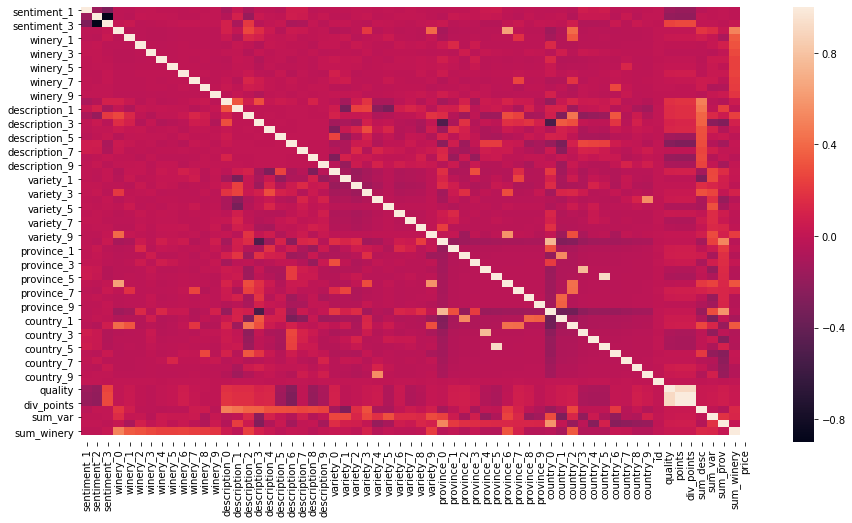

In [147]:
plt.figure(figsize=(15,8))
sns.heatmap(test_data.corr())

In [148]:
train_data.columns

Index(['sentiment_1', 'sentiment_2', 'sentiment_3', 'winery_0', 'winery_1',
       'winery_2', 'winery_3', 'winery_4', 'winery_5', 'winery_6', 'winery_7',
       'winery_8', 'winery_9', 'description_0', 'description_1',
       'description_2', 'description_3', 'description_4', 'description_5',
       'description_6', 'description_7', 'description_8', 'description_9',
       'variety_0', 'variety_1', 'variety_2', 'variety_3', 'variety_4',
       'variety_5', 'variety_6', 'variety_7', 'variety_8', 'variety_9',
       'province_0', 'province_1', 'province_2', 'province_3', 'province_4',
       'province_5', 'province_6', 'province_7', 'province_8', 'province_9',
       'country_0', 'country_1', 'country_2', 'country_3', 'country_4',
       'country_5', 'country_6', 'country_7', 'country_8', 'country_9', 'id',
       'quality', 'points', 'div_points', 'sum_desc', 'sum_var', 'sum_prov',
       'sum_winery', 'train_test', 'price'],
      dtype='object')

In [149]:
# train_data.head(2)

In [129]:
from sklearn import preprocessing


x = final_data[['sentiment_1', 'sentiment_2', 'sentiment_3', 'winery_0', 'winery_1',
       'winery_2', 'winery_3', 'winery_4', 'winery_5', 'winery_6', 'winery_7',
       'winery_8', 'winery_9', 'description_0', 'description_1',
       'description_2', 'description_3', 'description_4', 'description_5',
       'description_6', 'description_7', 'description_8', 'description_9',
       'variety_0', 'variety_1', 'variety_2', 'variety_3', 'variety_4',
       'variety_5', 'variety_6', 'variety_7', 'variety_8', 'variety_9',
       'province_0', 'province_1', 'province_2', 'province_3', 'province_4',
       'province_5', 'province_6', 'province_7', 'province_8', 'province_9',
       'country_0', 'country_1', 'country_2', 'country_3', 'country_4',
       'country_5', 'country_6', 'country_7', 'country_8', 'country_9'
                , 'id', 'quality', 'points', 'div_points',
       'sum_desc', 'sum_var', 'sum_prov', 'sum_winery']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = ['sentiment_1', 'sentiment_2', 'sentiment_3', 'winery_0', 'winery_1',
       'winery_2', 'winery_3', 'winery_4', 'winery_5', 'winery_6', 'winery_7',
       'winery_8', 'winery_9', 'description_0', 'description_1',
       'description_2', 'description_3', 'description_4', 'description_5',
       'description_6', 'description_7', 'description_8', 'description_9',
       'variety_0', 'variety_1', 'variety_2', 'variety_3', 'variety_4',
       'variety_5', 'variety_6', 'variety_7', 'variety_8', 'variety_9',
       'province_0', 'province_1', 'province_2', 'province_3', 'province_4',
       'province_5', 'province_6', 'province_7', 'province_8', 'province_9',
       'country_0', 'country_1', 'country_2', 'country_3', 'country_4',
       'country_5', 'country_6', 'country_7', 'country_8', 'country_9'
                , 'id', 'quality', 'points', 'div_points',
       'sum_desc', 'sum_var', 'sum_prov', 'sum_winery']
df.head(2)

,sentiment_1,sentiment_2,sentiment_3,winery_0,winery_1,winery_2,winery_3,winery_4,winery_5,winery_6,...,country_8,country_9,id,quality,points,div_points,sum_desc,sum_var,sum_prov,sum_winery
0,0.0,0.0,1.0,0.000046,0.016694,0.002545,0.125785,0.017291,0.076775,0.087207,...,1.308231e-09,3.867931e-08,0.212199,0.333333,0.448627,0.448627,0.510014,0.090488,0.005039,0.048921
1,0.0,0.0,1.0,0.223172,0.017345,0.002711,0.115214,0.017190,0.077300,0.088673,...,1.308237e-09,3.867931e-08,0.470943,0.333333,0.408345,0.408345,0.450321,1.000000,0.999887,0.169951


In [130]:
final_data = pd.concat([df,final_data['train_test'],final_data['price']],axis = 1)

In [131]:
final_data.columns

Index(['sentiment_1', 'sentiment_2', 'sentiment_3', 'winery_0', 'winery_1',
       'winery_2', 'winery_3', 'winery_4', 'winery_5', 'winery_6', 'winery_7',
       'winery_8', 'winery_9', 'description_0', 'description_1',
       'description_2', 'description_3', 'description_4', 'description_5',
       'description_6', 'description_7', 'description_8', 'description_9',
       'variety_0', 'variety_1', 'variety_2', 'variety_3', 'variety_4',
       'variety_5', 'variety_6', 'variety_7', 'variety_8', 'variety_9',
       'province_0', 'province_1', 'province_2', 'province_3', 'province_4',
       'province_5', 'province_6', 'province_7', 'province_8', 'province_9',
       'country_0', 'country_1', 'country_2', 'country_3', 'country_4',
       'country_5', 'country_6', 'country_7', 'country_8', 'country_9', 'id',
       'quality', 'points', 'div_points', 'sum_desc', 'sum_var', 'sum_prov',
       'sum_winery', 'train_test', 'price'],
      dtype='object')

In [152]:
X = train_data[[ 'winery_0', 'winery_1',
       'winery_2', 'winery_3', 'winery_4', 'winery_5', 'winery_6', 'winery_7',
       'winery_8', 'winery_9', 'description_0', 'description_1',
       'description_2', 'description_3', 'description_4', 'description_5',
       'description_6', 'description_7', 'description_8', 'description_9',
       'variety_0', 'variety_1', 'variety_2', 'variety_3', 'variety_4',
       'variety_5', 'variety_6', 'variety_7', 'variety_8', 'variety_9',
       'province_0', 'province_1', 'province_2', 'province_3', 'province_4',
       'province_5', 'province_6', 'province_7', 'province_8', 'province_9','id'
                , 'points', 'div_points', 'sum_desc', 'sum_var', 'sum_prov',
       'sum_winery']]
y = train_data["price"]

In [153]:
X.shape

(175000, 47)

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [155]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(122500, 47) (52500, 47) (122500,) (52500,)


In [156]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

/home/aims/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [157]:
#Set xgboost parameters
param = {'max_depth': 3, 'eta': 1, 'subsample':0.5, 'alpha':1}
param['nthread'] = 4
param['eval_metric'] = 'mae'
param['objective'] = 'reg:linear'
param['silent'] = 1
evallist = [(dtrain, 'train')]
num_round = 15

#Train model
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	train-mae:15.1082
Will train until train-mae hasn't improved in 10 rounds.
[1]	train-mae:14.5547
[2]	train-mae:14.4914
[3]	train-mae:14.2082
[4]	train-mae:13.8548
[5]	train-mae:13.8533
[6]	train-mae:13.8224
[7]	train-mae:13.7984
[8]	train-mae:13.7721
[9]	train-mae:13.7182
[10]	train-mae:13.6729
[11]	train-mae:13.6371
[12]	train-mae:13.5517
[13]	train-mae:13.5383
[14]	train-mae:13.5589


In [158]:
pred = pd.DataFrame(y_test.copy())
pred["prediction"] = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

In [159]:
rmse = np.round(np.sqrt(mean_squared_error(y_true=pred["price"], y_pred=pred["prediction"])), 2)
print ("Mean Squared Error: {} ".format(rmse))

Mean Squared Error: 30.44 


In [160]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

In [161]:
lm = Ridge()

lm.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [162]:
print(lm.intercept_)

-0.8945117201006312


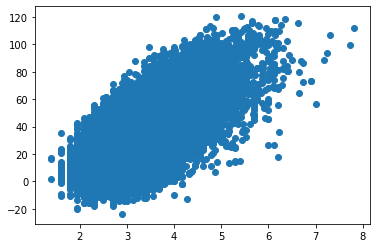

In [163]:
predictions = lm.predict(X_test)
plt.scatter(np.log(y_test),predictions)

In [164]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

RMSE: 34.16247829146815


In [165]:
rf = RandomForestRegressor()

In [166]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [167]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [168]:
predicts = rf.predict(X_test)

In [169]:
print(y_test.shape, predicts.shape)

(52500,) (52500,)


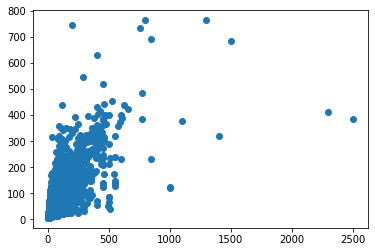

In [170]:
plt.scatter(y_test, predicts)

In [171]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, predicts)))

RMSE: 24.858854481647267


In [172]:
importance = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(rf.feature_importances_)],axis=1)
# importance.columns = ['feature','value']

plt.figure(figsize=(15,8))
sns.barplot(x="feature", y="value", data=importance).set_xticklabels(rotation=90,labels=X_train.columns)

TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'

<Figure size 1080x576 with 0 Axes>

In [173]:
test_data.columns

Index(['sentiment_1', 'sentiment_2', 'sentiment_3', 'winery_0', 'winery_1',
       'winery_2', 'winery_3', 'winery_4', 'winery_5', 'winery_6', 'winery_7',
       'winery_8', 'winery_9', 'description_0', 'description_1',
       'description_2', 'description_3', 'description_4', 'description_5',
       'description_6', 'description_7', 'description_8', 'description_9',
       'variety_0', 'variety_1', 'variety_2', 'variety_3', 'variety_4',
       'variety_5', 'variety_6', 'variety_7', 'variety_8', 'variety_9',
       'province_0', 'province_1', 'province_2', 'province_3', 'province_4',
       'province_5', 'province_6', 'province_7', 'province_8', 'province_9',
       'country_0', 'country_1', 'country_2', 'country_3', 'country_4',
       'country_5', 'country_6', 'country_7', 'country_8', 'country_9', 'id',
       'quality', 'points', 'div_points', 'sum_desc', 'sum_var', 'sum_prov',
       'sum_winery', 'train_test', 'price'],
      dtype='object')

In [187]:
test_data['countries3_8']=test_data.country_3*test_data.country_4*test_data.country_5*test_data.country_6*test_data.country_7*test_data.country_8

In [191]:
X_test_t = test_data[['sentiment_1', 'sentiment_2', 'sentiment_3', 'winery_0', 'winery_1',
       'winery_2', 'winery_3', 'winery_4', 'winery_5', 'winery_6', 'winery_7',
       'winery_8', 'winery_9', 'description_0', 'description_1',
       'description_2', 'description_3', 'description_4', 'description_5',
       'description_6', 'description_7', 'description_8', 'description_9',
       'variety_0', 'variety_1', 'variety_2', 'variety_3', 'variety_4',
       'variety_5', 'variety_6', 'variety_7', 'variety_8', 'variety_9',
       'province_0', 'province_1', 'province_2', 'province_3', 'province_4',
       'province_5', 'province_6', 'province_7', 'province_8', 'province_9',
       'country_0', 'country_1', 'country_2', 'country_3', 'country_4',
       'country_5', 'country_6', 'country_7', 'country_8', 'country_9', 'id',
       'quality', 'points', 'div_points', 'sum_desc', 'sum_var', 'sum_prov',
       'sum_country', 'sum_winery']]

In [193]:
test_data['price'] = rf.predict(X_test_t)
test_data['price'].head()

175000    180.504
175001     66.637
175002     48.521
175003     35.568
175004     14.241
Name: price, dtype: float64

In [194]:
test_data[['id', 'price']].to_csv('bma_price_predicted_rmse22.30.csv', index=False)

In [195]:
#pd.DataFrame(test_data_sss).to_csv('random_f.csv')

In [196]:
import pickle

In [197]:
pickle.dump(rf,open('rf_model_rmse14_22.sav','wb'))